# 7.6 컨볼루션 신경망 구션(CNN)
* 0에서 9까지 손글씨로 쓴 숫자 이미지 데이터로 데이터는 각 이미지가 어떤 숫자인지를 나타내는 정답도 함께 포함

## 7.6.1 사용 데이터 세트

In [21]:
import matplotlib.pyplot as plt
from sklearn import datasets  #손글씨 숫자 데이터 세트

from IPython.display import Image

(1797, 64)


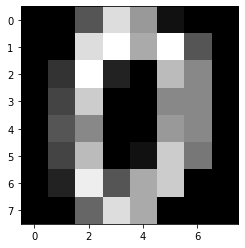

In [13]:
digits = datasets.load_digits()
print(digits.data.shape)

plt.imshow(digits.data[0].reshape(8,8), cmap = "gray")
plt.show()

In [14]:
print(digits.target.shape)
print(digits.target[:50])

(1797,)
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 8 9 8 4 1 7 7 3 5 1 0 0]


## 7.6.2 구축할 신경망

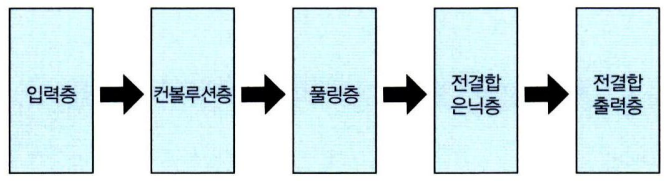

* 컨볼루션층의 활성화 함수 : ReLU
* 은닉층의 활성화 함수 : ReLU
* 출력층의 활성화 함수 : 소프트맥수 함수
* 손실함수 : 교차 엔트로피 오차
* 최적화 알고리즘 : 아다그라드
* 배치 사이즈 : 8

## 7.6.3 CNN 코드

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [34]:
#--손글씨 숫자 데이터 불러오기--
digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)

#--입력 데이터 표준화
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

#--정답을 원핫 인코딩으로 표현--
correct_data = np.zeros((n_data, 10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0
    
#--훈련 데이터와 테스트 데이터--
index = np.arange(n_data)
index_train = index[index%3 != 0]
index_test = index[index%3 == 0]

input_train = input_data[index_train, :]         #훈련 데이터 입력
correct_train = correct_data[index_train, :]     # 훈련 데이터 정답
input_test = input_data[index_test, :]           # 테스트 데이터 입력
correct_test = correct_data[index_test, :]       # 테스트 데이터 정답

n_train = input_train.shape[0]    # 훈련 데이터 샘플 수
n_test = input_test.shape[0]      # 테이스 데이터 샘플 수

In [35]:
##--각 설정 값--
img_h = 8    # 입력 이미지의 높이
img_w = 8    # 입력 이미지의 너비
img_ch = 1   # 입력 이미지 채널 수

wb_width = 0.1    # 가중치와 편향 설정을 위한 정규분포 표준편차
eta = 0.01        # 학습률
epoch = 50
batch_size = 8
interval = 10     # 경과 표시 간격
n_sample = 200    # 오차 계산 샘플 수

In [43]:
##--im2col--
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
    
    n_bt, b_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0.0), (0.0), (pad, pad),(pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch,flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + stride * out_h
        for w in range(flt_w):
            w_lim = w + stride * out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]
            
        cols = cols,transpose(1, 2, 3, 0, 4, 5).reshape(
            n_ch*flt_h*flt_w, n_bt*out_h*out_w)
        return cols
    
#--col2im--
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
    
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, b_bt, out_h, out_w).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, b_ch, img+h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += col[:, :, h, w, :, :]
            
            return images[:, :, pad:img_h+pad, pad:img_w+pad]

In [57]:
##--컨볼루션 층--
class ConvLayer:
    # n_bt : 배치 사이즈, x_ch : 입력 채널 수
    # x_h : 입력 이미지 높이, x_w : 입력 이미지 너비
    # n_fit : 필터 수, fit_h : 필터 높이, fit_w : 필터 너비
    # stride : 스트라이드 너비, pad : 패딩 너비
    # y_ch : 출력 채널 수, y_h : 출력 높이, y_w : 출력 너비
    
    def __init__(self, x_ch, x_h, x_w, n_fㅣt, flt_h, flt_w, stride, pad):
        
        # 파라미터 정리
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # 필터와 편향 초깃값
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        self.y_ch = n_flt  # 출력 채널 수
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  # 출력 높이
        self.y_w = (x_w - fit_w + 2*pad) // stride + 1  # 출력 너비
        
        # 아다그리드(AdaGrad)
        self.h_w = np.zeros((n_flt, x_ch, fit_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 입력이미지와 필터를 행렬로 변환
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        # 출력 계산 : 행렬 곱, 편향 더하기, 활성화 함수
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y,w = self.y_ch, self.y_h, self.y_w
        
        # data
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        # 필터와 편향 기울기
        grad_w = np.dot(selt.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis = 0)
        
        # 입력 기울기
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b * self.grad_b)

In [58]:
#--풀링층--
class PoolingLayer:
    
    # n_bt : 배치사이즈, x_ch : 입력 채널 수,
    # x_h : 입력 이미지 높이, x_w : 입력 이미지 너비
    # pool : 풀링 영역 크기, pad : 패딩 너비
    # y_ch : 출력 채널 수, y_h : 출력 높이, y_w : 출력 너비
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        # 파라미터 정리
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        self.y_ch = x_ch   # 츌력 채널 수
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1   # 출력 높비
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1   # 출력 너비
        
    def forward(self, x):
        b_bt = x.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 입력 이미지를 행렬로 변환
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        # 출력 계산 : 맥스풀링
        y = np.max(cols, axis = 1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        # 최댓값 인덱스 저장
        self.max_index = np.argmax(cols, axis = 1)
        
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 출력 기울기의 축 변경
        grad_y = grad_y.traspose(0, 2, 3, 1)
        
        # 행렬 생성
        grad_cols = np.zeros((pool*pool, grad_y.size))
        # 각 열의 최댓값이 있던 위치에 출력 기울기 입력
        grad_cols[self.max_index.reshape(-1),
                 np.arange(grad_y.size)] = grad_y.reshape(-1)
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5, 0, 1, 2, 3, 4)
        grad_cols = grad_cols.reshape(y_ch*pool*pool, n_bt*y_h*y_w)
        
        # 입력 기울기
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

In [59]:
#--전결합층의 부모 클래스--
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        
        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
        
#--전결합 은닉층--
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
        
#--전결합 출력층--
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
    #--각 층의 초기화--
    cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
    pl_1 = PoolingLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 2, 0)

    n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
    ml_1 = MiddleLayer(n_fc_in, 100)
    ol_1 = OutputLayer(100, 10)
        
    #--순전파--
    def forward_propagation(x):
        n_bt = x.shape[0]
        
        images = x.reshape(n_bt, img_ch, img_h, img_w)
        cl_1.forward(images)
        pl_1.forward(cl_1.y)
        
        fc_input = pl_1.y.reshape(n_bt, -1)
        ml_1.forward(fc_input)
        ol_1.forward(ml_1.y)
        
    #--역전파--
    def backpropagation(t):
        n_bt = t.shape[0]
        
        ol_1.backward(t)
        ml_1.backward(ol_1.grad_x)
        
        grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
        pl_1.backward(grad_img)
        cl_1.backward(pl_1.grad_x)
        
    #--가중치와 편향 수정--
    def uppate_wb():
        cl_1.update(eta)
        ml_1.update(eta)
        ol_1.update(eta)
        
    #--교차 엔트로피 오차 계산
    def get_error(t,batch_size):
        return -np.sum(t*np.log(ol_1.y + 1e-7)) / batch_size
    
    #--샘플을 순전파--
    def forward_sample(inp, correct, n_sample):
        index_rand = np.arange(len(correct))
        np.random.shuffle(inded_rand)
        index_rand = index_rand[:n_sample]
        x = inp[index_rand, :]
        t = correct[index_rand, :]
        forward_propagation(x)
        return x, t

NameError: name 'n_flt' is not defined